# Import

In [1]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
%matplotlib inline

# Import data

In [2]:
df = pd.read_csv('Wholesale customers data.csv')

# Exploratory data analysis

In [3]:
df.drop('Region',axis=1).groupby('Channel').describe()

Fresh                                                               \
         count          mean           std   min      25%     50%       75%   
Channel                                                                       
1        298.0  13475.560403  13831.687502   3.0  4070.25  9581.5  18274.75   
2        142.0   8904.323944   8987.714750  18.0  2347.75  5993.5  12229.75   

                    Milk                ... Detergents_Paper           \
              max  count          mean  ...              75%      max   
Channel                                 ...                             
1        112151.0  298.0   3451.724832  ...            899.5   6907.0   
2         44466.0  142.0  10716.500000  ...           8662.5  40827.0   

        Delicassen                                                         \
             count         mean          std  min     25%     50%     75%   
Channel                                                                     
1            298.0  1415.956376  3147.426922  3.0  379.00   821.0  1548.0   
2            142.0  1753.436620  1953.797047  3.0  566.75  1350.0  2156.0   

                  
             max  
Channel           
1        47943.0  
2        16523.0  

[2 rows x 48 columns]

# Paired scatter plots

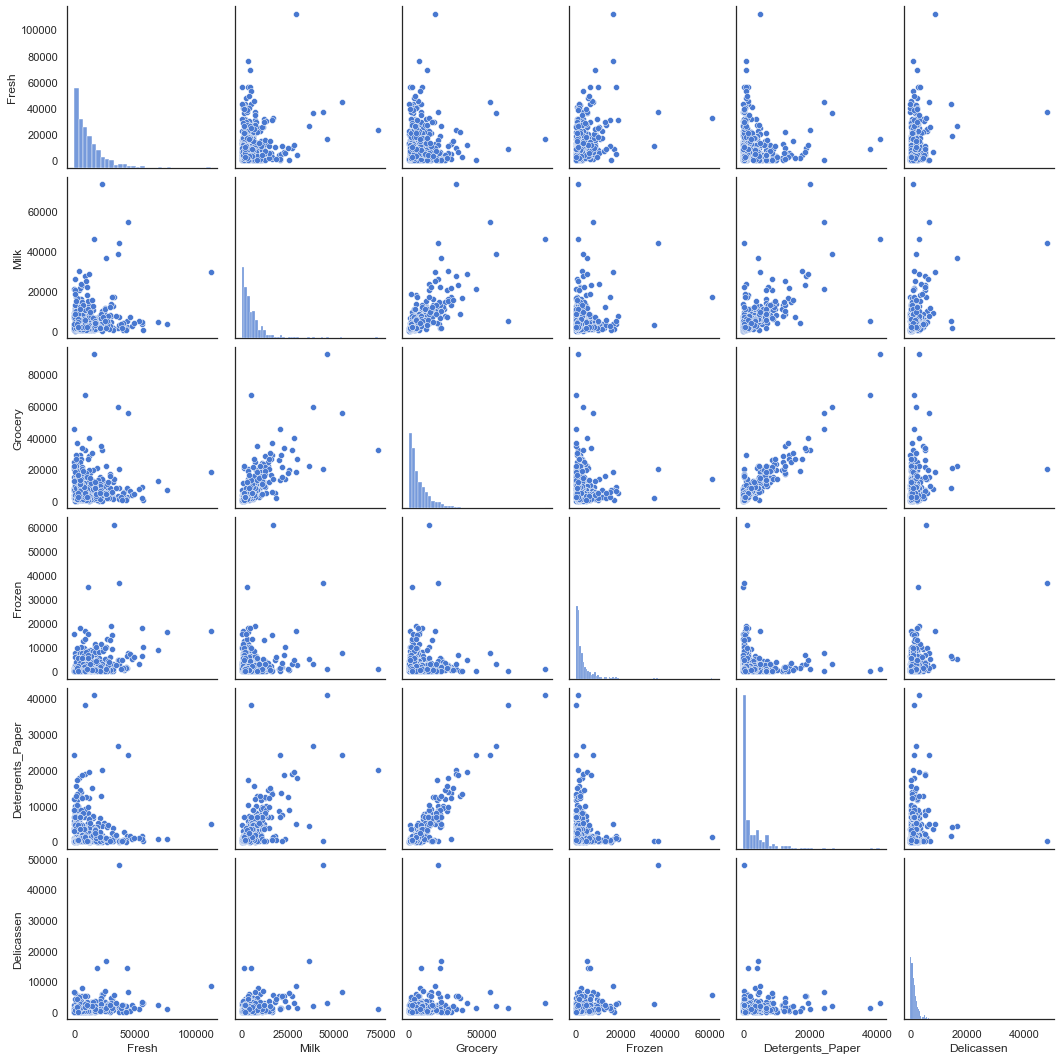

In [4]:
sns.set(
    style="white", 
    palette="muted"
)
sns_plot = sns.pairplot(df.drop(['Channel','Region'], axis =1))

# Correlation matrix

In [5]:
corrs = df.drop(['Channel','Region'], axis =1).corr()
fig = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
fig.show()

# Data Preprocessing

In [6]:
log_data =  np.log(df.drop(['Channel','Region'], axis =1).copy())

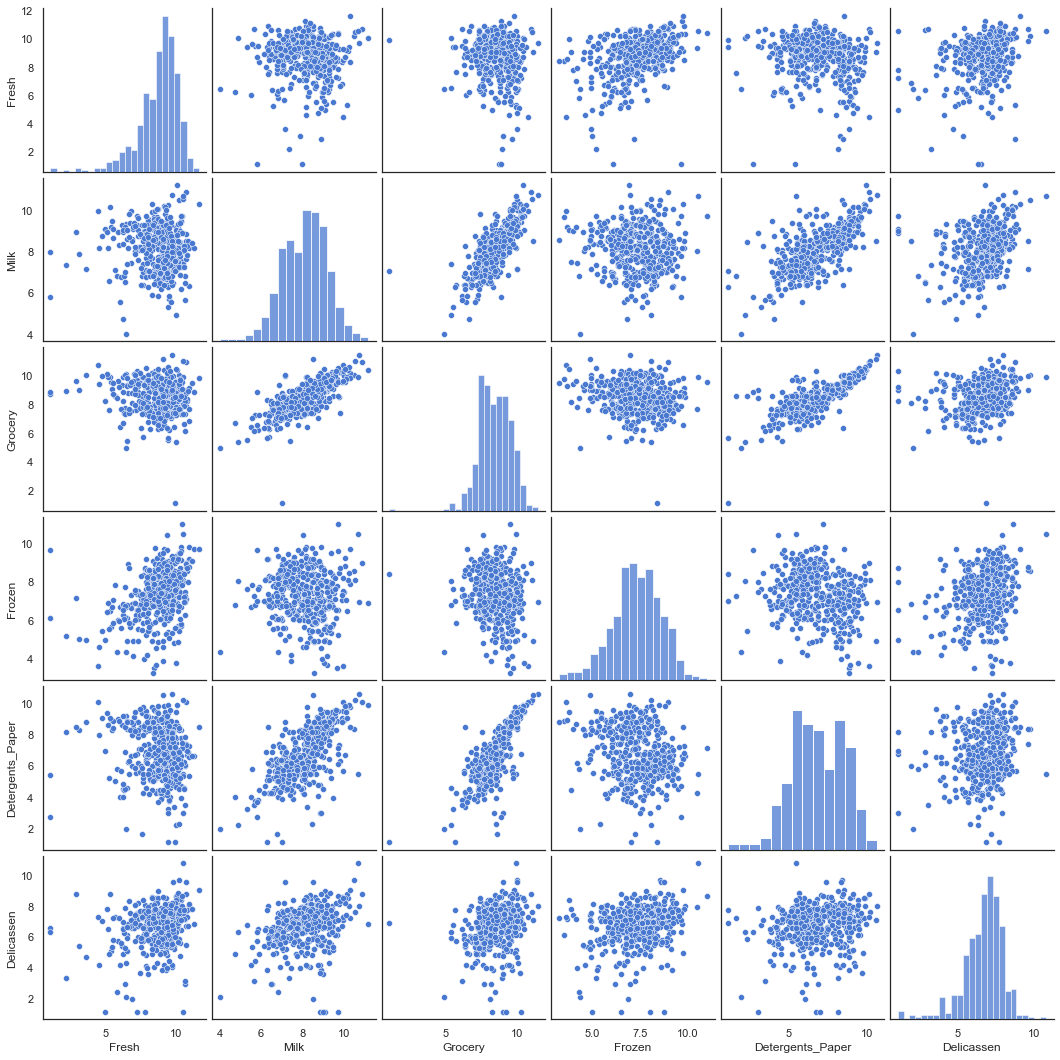

In [7]:
sns_plot = sns.pairplot(log_data)

# PCA

In [8]:
from sklearn.decomposition import PCA 
for i in range(1,7):
    pca = PCA(n_components=i).fit(log_data)
    print('n_components = {}, Explained Variance = {}'.format(i, sum(pca.explained_variance_ratio_)))

n_components = 1, Explained Variance = 0.44237416641831717
n_components = 2, Explained Variance = 0.7189452317370727
n_components = 3, Explained Variance = 0.8351186513381146
n_components = 4, Explained Variance = 0.9312958450547781
n_components = 5, Explained Variance = 0.977052648112909
n_components = 6, Explained Variance = 0.9999999999999999


In [9]:
principalComponents  = PCA(n_components=2).fit_transform(log_data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Clustering

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [11]:
for i in range(2,11):
    model = KMeans(i).fit(principalDf)
    preds = model.predict(principalDf)
    print("n_cluster = {}, silhouette_score = {}".format(i, silhouette_score(principalDf, preds)))

n_cluster = 2, silhouette_score = 0.419166083202923
n_cluster = 3, silhouette_score = 0.39347319148245263
n_cluster = 4, silhouette_score = 0.3298292356581139
n_cluster = 5, silhouette_score = 0.35171159325416756
n_cluster = 6, silhouette_score = 0.35214150697234237
n_cluster = 7, silhouette_score = 0.36471685233792733
n_cluster = 8, silhouette_score = 0.35655109270856195
n_cluster = 9, silhouette_score = 0.3617211411252232
n_cluster = 10, silhouette_score = 0.35764447803009153


# Visualization

In [12]:
import plotly.express as px

In [13]:
model = KMeans(2).fit(principalDf)
preds = model.predict(principalDf)

In [14]:
principalDf['preds'] = preds
principalDf['Channel'] = df['Channel']
principalDf['preds'] = principalDf['preds'].astype(str)
principalDf['Channel'] = principalDf['Channel'].astype(str)

In [15]:
principalDf

principal component 1  principal component 2 preds Channel
0                -1.750985              -0.070515     0       2
1                -1.800365              -0.869754     0       2
2                -1.893736              -1.676621     0       2
3                 1.127313              -1.457982     1       1
4                -0.796711              -2.460866     0       2
..                     ...                    ...   ...     ...
435               0.606085              -2.892035     1       1
436               3.184892              -2.007764     1       1
437              -3.747931              -0.927207     0       2
438               1.657972              -0.476035     1       1
439               0.737900               3.634438     1       1

[440 rows x 4 columns]

In [16]:
fig = px.scatter(principalDf, x="principal component 1", y="principal component 2", color="preds")
fig.show()

In [17]:
fig = px.scatter(principalDf, x="principal component 1", y="principal component 2", color="Channel")
fig.show()

In [18]:
from sklearn.metrics import f1_score

In [19]:
conv = {
    '2': '0',
    '1': '1'
}
principalDf['channel_conv'] = principalDf['Channel'].apply(lambda x: conv[x])

In [20]:
f1_score(principalDf['channel_conv'], principalDf['preds'], pos_label="1")

0.9142857142857143

# Classification

### Random Forest

In [21]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [22]:
df['Region'] = df['Region'].astype('str')
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['Region']])
df_1 = pd.DataFrame(enc.transform(df[['Region']]).toarray(), columns=['reg1','reg2', 'reg3'])

X = pd.concat([log_data, df_1], axis=1)
y = df['Channel']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [54]:
clf = DecisionTreeClassifier() 
clf = clf.fit(X_train,y_train)  
y_pred = clf.predict(X_test)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93        60
           2       0.86      0.86      0.86        28

    accuracy                           0.91        88
   macro avg       0.90      0.90      0.90        88
weighted avg       0.91      0.91      0.91        88



### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

In [74]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [75]:
f1_score(y_test, y_pred)

0.9281767955801105

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.95      0.93        88
           2       0.90      0.80      0.84        44

    accuracy                           0.90       132
   macro avg       0.90      0.88      0.89       132
weighted avg       0.90      0.90      0.90       132

